# 🤗 Glokking conditional Latent DDPM (image-to-image) with Diffusers

This script dives deep into the method of (latent) DDPM.

### Installing the dependencies

[Custimized] This notebook leverages the customized dataset and its dataloader (.mat, .raw) 

[OPTION] [🤗 Datasets](https://huggingface.co/docs/datasets/index) library to load

[CUDA] The [🤗 Accelerate](https://huggingface.co/docs/accelerate/index) library to simplify training on any number of GPUs, with features like automatic gradient accumulation and tensorboard logging. Let's install them here:

In [1]:
#!pip install --upgrade diffusers[torch]
#!pip install datasets
#!pip install transformers

### Tested enviroment
nvcc: NVIDIA (R) Cuda compiler driver

Copyright (c) 2005-2022 NVIDIA Corporation

Cuda compilation tools, release 11.6, V11.6.124

Build cuda_11.6.r11.6/compiler.31057947_0

Python version 3.9.16

Torch version 1.13.1

In [2]:
# running environment
!nvcc --version
!python --version
import torch
print(torch.__version__)
torch.cuda.set_device(0)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
Python 3.9.16
1.13.1


### Open source

[Optional] To be able to share your model with the community, there are a few more steps to follow.|

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your **write** token:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Config

For convenience, we define a configuration grouping all the training hyperparameters. This would be similar to the arguments used for a [training script](https://github.com/huggingface/diffusers/tree/main/examples).
Here we choose reasonable defaults for hyperparameters like `num_epochs`, `learning_rate`, `lr_warmup_steps`, but feel free to adjust them if you train on your own dataset. For example, `num_epochs` can be increased to 100 for better visual quality.

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    
    latent_diffusion = True
    
    output_dir = 'train/test'  # the model namy locally and on the HF Hub
    pretrain_dir = 'train/ldct2' # the pretrained model namy locally and on the HF Hub
    
    image_size = 512 # the generated image resolution
    image_channel = 1 # must use to_rgb during training and inference if vae is preloaded
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    num_train_timesteps = 1000
    num_inference_timesteps = 1000
    data_augmentation = True
    
    # learning rate
    lr_scheduler_type = "constant_with_warmup"
    # choose from "linear", "cosine", "cosine_with_restarts", "polynomial","constant", "constant_with_warmup"]'
    learning_rate = 1e-4
    lr_warmup_steps = 500
    
    # optimization
    mixed_precision = 'no'  # `no` for float32, `fp16` for automatic mixed precision, `bp16`
    gradient_accumulation_steps = 1
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    
    # model save
    save_image_epochs = 5
    save_model_epochs = 10
    pretrained_model_name_or_path = "stabilityai/stable-diffusion-x4-upscaler"
    # 'CompVis/ldm-super-resolution-4x-openimages'
    #'runwayml/stable-diffusion-v1-5' #'CompVis/stable-diffusion-v1-5'
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

## Loading the dataset

[OPTION 1] Load local folders with a loading script.

[OPTION 2] Use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our image dataset.

In [5]:
import datasets
from datasets import load_dataset

# existing hub dataset
# config.dataset = "huggan/smithsonian_butterflies_subset"
 
# Or just load images from a local folder with a loading script
# change versions if needed
train_cases = (0, 305)
val_cases = (5177, 5482)
test_cases = (5482, 5829)

dataset = load_dataset(
    path = '/mnt/ssd_256/mayo_CT',
    name = 'AAPM Low Dose Dataset',
    data_dir = '/mnt/ssd_256/mayo_CT',
    cache_dir = "./data",
    img_height = config.image_size,
    img_width = config.image_size,
    splits = {datasets.Split.TRAIN: train_cases, datasets.Split.VALIDATION: val_cases , datasets.Split.TEST: test_cases}
)

Found cached dataset mayo_ct (/mnt/hdd_2T/Diffusion-Chengzhu/data/mayo_ct/AAPM Low Dose Dataset-da3c860ae8ad0434/1.0.0/73bc0de4a87fb79a6f2257263320c370bf467476ed5f34102249fa863d264d62)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset contains the splitted labels and several extra `features` (columns), but the one that we're interested in is `image`. Note that these images are stacked as a list if we load them from .raw or .mat. We must convert it to numpy(lossless), pil(lossy if rgb) or tensor.

In [6]:
dataset
print('Data type:', type(dataset["train"][0]["imageA"]))

Data type: <class 'list'>


Since the [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) feature loads the images with PIL, we can easily look at a few examples:

/tmp/ipykernel_2932245/2392659302.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2932245/2392659302.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


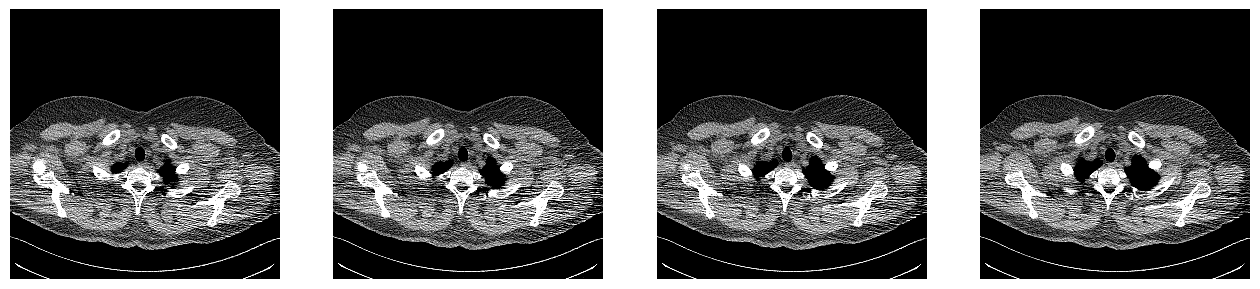

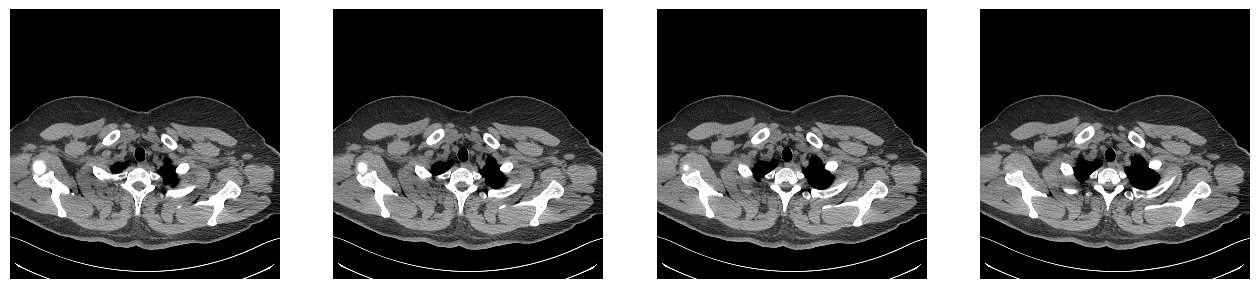

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

l, r = 25, 400
win_min, win_max = (l-r/2+1024)/4095, (l+r/2+1024)/4095

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][20:24]["imageA"]):
    image = np.array(image, dtype=np.float32)
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][20:24]["imageB"]):
    image = np.array(image, dtype=np.float32)
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()


## Prepare data for augmentation
The images in the dataset are all different, so we need to preprocess them first:
* `Resize` makes the images conform to a square resolution of `config.image_size`
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `RandomVerticalFlip` augments the dataset by randomly flip the images.
* `Normalize` is important to rescale the pixel values into a `[-1, 1]` range (which our model will expect).

Trick: for gray scale images, make sure to perform data augmentation first, and then sent it to rgb if needed.

In [8]:
from torchvision import transforms

# todo config paired data_augmentation
# seed = np.random.randint(2147483647)
# random.seed(seed)
# torch.manual_seed(seed)

norm_mean, norm_scale = 0.5, 0.5
preprocess = transforms.Compose(
    [
        #transforms.ToPILImage(),
        #transforms.Resize((config.image_size, config.image_size)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([norm_mean], [norm_scale]),
    ]
)

🤗 Datasets offer a handy `set_transform()` method to apply the image transformations on the fly during training:

In [9]:
import random

def to_rgb(grayscale_image):
    return grayscale_image.repeat(1, 3, 1, 1)    # batch, channel, height, width
    
def transform(examples):
    imagesA = [preprocess(np.array(image, dtype=np.float32)) for image in examples["imageA"]]
    imagesB = [preprocess(np.array(image, dtype=np.float32)) for image in examples["imageB"]]
    return {"imageA": imagesA, "imageB": imagesB}

dataset.set_transform(transform)

Let's view the transformed image tensor through piepline.

/tmp/ipykernel_2932245/3786803854.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2932245/3786803854.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


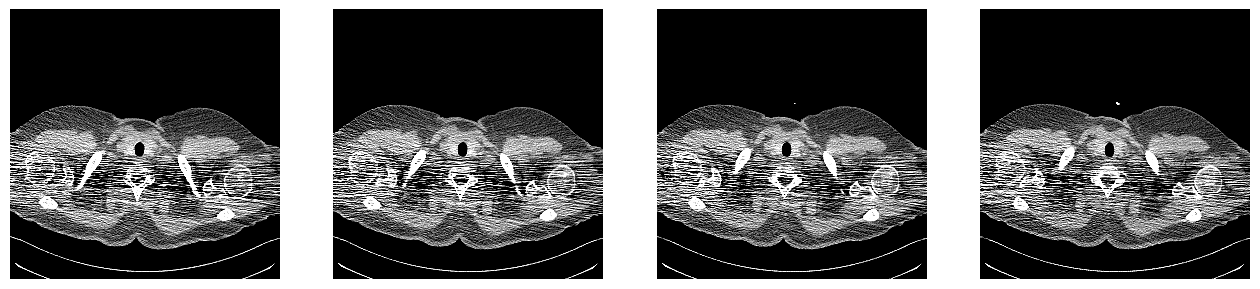

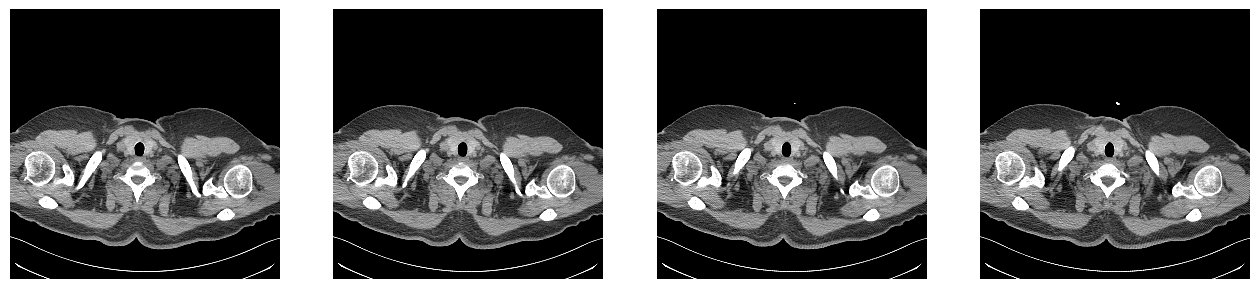

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["imageA"]):
    image = image.permute(1, 2, 0)
    axs[i].imshow(image * norm_scale + norm_mean, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["imageB"]):
    image = image.permute(1, 2, 0)
    axs[i].imshow(image * norm_scale + norm_mean, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.

In [11]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=config.train_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset['validation'], batch_size=config.eval_batch_size, shuffle=True)


## Defining the diffusion model

Here we set up our diffusion model. Diffusion models are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform a random noise to generate an image:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).

The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch. The models in our case is preset and saved in model.py. Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram).


In [12]:
from diffusers import UNet2DModel, AutoencoderKL, VQModel
#from models import UNet2DModel_Superres

if config.latent_diffusion:
    in_channels = 4
else:
    # TODO: if load from hub, chances are input channel requires 3, therefore torgb needed
    in_channels = config.image_channel

if config.pretrain_dir is None:  
    model = UNet2DModel(
        sample_size=config.image_size,  # the target image resolution
        in_channels=in_channels*2,  # the number of input channels, 3 for RGB images, 3 for latents
        out_channels=in_channels,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
        down_block_types=( 
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D", 
            "DownBlock2D", 
            "DownBlock2D", 
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ), 
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D", 
            "UpBlock2D", 
            "UpBlock2D", 
            "UpBlock2D"  
          ),
    )   
#     model = UNet2DModel_Superres(        
#         sample_size=config.image_size,  # the target image resolution
#         in_channels=in_channels*2,  # the number of input channels, 3 for RGB images, 3 for latents
#         out_channels=in_channels,  # the number of output channels
#     )
else:
    model = UNet2DModel.from_pretrained(config.pretrain_dir, subfolder="unet")

if config.latent_diffusion:
    #vae = VQModel.from_pretrained(config.pretrained_model_name_or_path, subfolder="vae")
    vae = AutoencoderKL.from_pretrained(config.pretrained_model_name_or_path, subfolder="vae")
    vae.requires_grad_(False)

## VAE: reduce dimensionality
VAE is used to reduce dimensionality. How does it perform on the CT dataset if no fine-tuning is used.

In [13]:
vae.config.scaling_factor
vae = vae.cuda()

In [14]:
# Using torchvision.transforms.ToTensor
def image_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(input_im.cuda()) # Note scaling
    return vae.config.scaling_factor * latent.latent_dist.sample() # or .mean or .sample

def latent_to_image(latent):
    # bath of latents -> list of images
    latent = (1 / vae.config.scaling_factor ) * latent
    with torch.no_grad():
        image = vae.decode(latent).sample
    image = torch.clamp(image, -1.0, 1.0)
    image = image.detach().cpu().permute(0, 2, 3, 1)
    return image

def to_gray(rgb_im):
    return 0.2989*rgb_im[...,0] + 0.5870*rgb_im[...,1] + 0.1140*rgb_im[...,2]

In [27]:
image_idx = 215

input_image = dataset['validation'][image_idx]['imageA'].unsqueeze(0)
if config.latent_diffusion:
    input_image = to_rgb(input_image.float())
encodedA = image_to_latent(input_image)

input_image = dataset['validation'][image_idx]['imageB'].unsqueeze(0)
if config.latent_diffusion:
    input_image = to_rgb(input_image.float())
encodedB = image_to_latent(input_image)


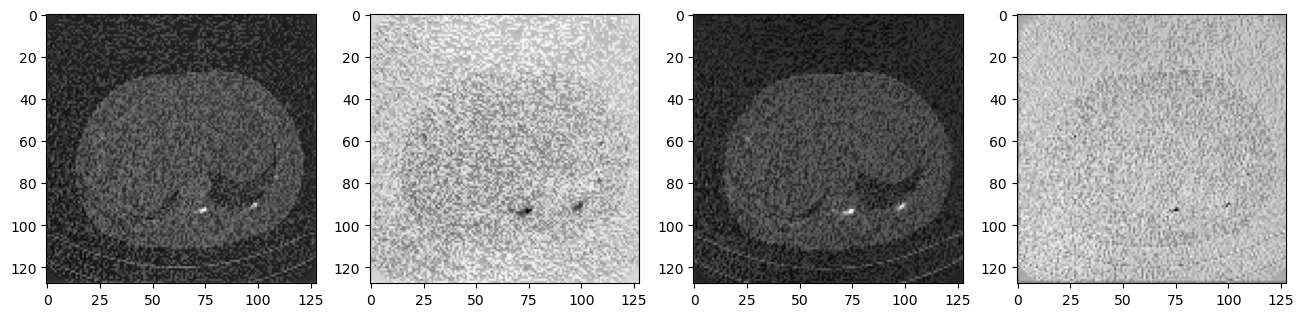

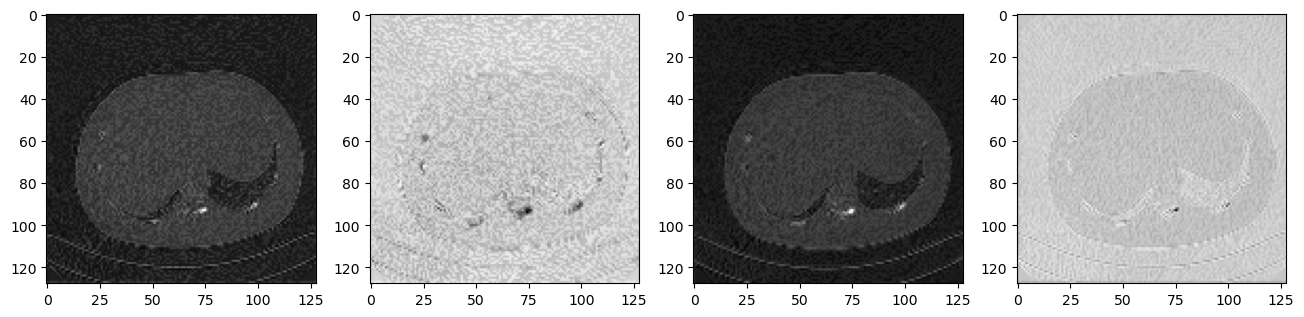

In [28]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encodedA[0][c].cpu(), cmap='Greys')
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encodedB[0][c].cpu(), cmap='Greys')    

In [29]:
decodedA = latent_to_image(encodedA)[0]
decodedB= latent_to_image(encodedB)[0]


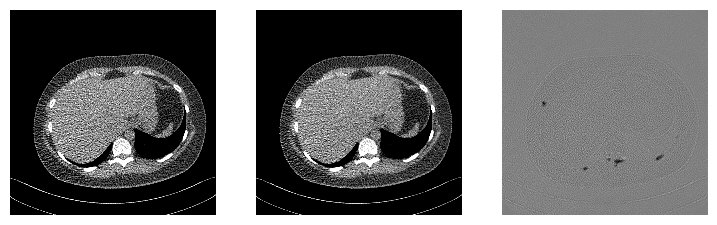

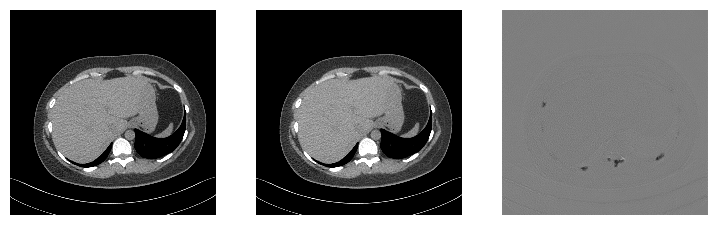

In [30]:
l, r = 25, 400
win_min, win_max = (l-r/2+1024)/4095, (l+r/2+1024)/4095

decodedA_gray = to_gray(decodedA)*norm_scale+norm_mean
decodedB_gray = to_gray(decodedB)*norm_scale+norm_mean
imageA = dataset["validation"][image_idx]["imageA"].permute(1, 2, 0).squeeze()*norm_scale+norm_mean
imageB = dataset["validation"][image_idx]["imageB"].permute(1, 2, 0).squeeze()*norm_scale+norm_mean
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(imageA, cmap='gray', vmin=win_min, vmax=win_max)
axs[0].set_axis_off()
axs[1].imshow(decodedA_gray, cmap='gray', vmin=win_min, vmax=win_max)
axs[1].set_axis_off()
axs[2].imshow(imageA - decodedA_gray, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].set_axis_off()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(imageB, cmap='gray', vmin=win_min, vmax=win_max)
axs[0].set_axis_off()
axs[1].imshow(decodedB_gray, cmap='gray', vmin=win_min, vmax=win_max)
axs[1].set_axis_off()
axs[2].imshow(imageB - decodedB_gray, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].set_axis_off()


## Conditional U-net by concatenation

Let's get a sample image from our dataset and pass it into our model. We just need to add a batch dimension:

In [20]:
# TODO: need to_rgb if load from hub. commend: rare situation, a bit tricky to implement
sample_image = dataset['train'][0]['imageB'].unsqueeze(0)
if config.latent_diffusion:
    sample_image = vae.encode(to_rgb(sample_image.cuda())).latent_dist.sample()
    sample_image = vae.config.scaling_factor * sample_image
print('Condition:', sample_image.shape)
condition_image = dataset['train'][0]['imageA'].unsqueeze(0)
if config.latent_diffusion:
    condition_image  = vae.encode(to_rgb(condition_image.cuda())).latent_dist.sample()
    condition_image  = vae.config.scaling_factor * condition_image 
input_image = torch.cat([sample_image, condition_image], dim=1)
print('Input shape:', input_image.shape)

Condition: torch.Size([1, 4, 128, 128])
Input shape: torch.Size([1, 8, 128, 128])


In [21]:
model = model.cuda()
print('Output shape:', model(input_image, timestep=0)["sample"].shape)

Output shape: torch.Size([1, 4, 128, 128])


Note that our model takes in the (noisy) image and also the current time-step (as we saw before in the training overview). That time-step information is converted for the model using a sinusoidal positional embedding, similar to what Transformer models often do.

Now that we have our model, we just need an object to *add noise to an image*. This is done by the **schedulers** in the `diffusers` library.

## Defining the noise scheduler

Depending on the diffusion algorithm you want to use, the way images are noised is slightly different. That's why 🤗 Diffusers contains different scheduler classes which each define the algorithm-specific diffusion steps. Here we are going to use the `DDPMScheduler` which corresponds to the training denoising and training algorithm proposed in [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

And let's check the output is a tensor of the same exact shape:

In [22]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps)

#def __init__(
#    self,
#    num_train_timesteps: int = 1000,
#    beta_start: float = 0.0001,
#    beta_end: float = 0.02,
#    beta_schedule: str = "linear",
#    trained_betas: Optional[Union[np.ndarray, List[float]]] = None,
#    variance_type: str = "fixed_small",
#    clip_sample: bool = True,
#    prediction_type: str = "epsilon",
#    thresholding: bool = False,
#    dynamic_thresholding_ratio: float = 0.995,
#    clip_sample_range: float = 1.0,
#    sample_max_value: float = 1.0,
#)

# optional:
# DDIMScheduler,
# PNDMScheduler,
# LMSDiscreteScheduler,
# EulerDiscreteScheduler,
# EulerAncestralDiscreteScheduler,
# DPMSolverMultistepScheduler,

In [23]:
noise_scheduler.init_noise_sigma

1.0

You can see how our new set of steps corresponds to those used in training:

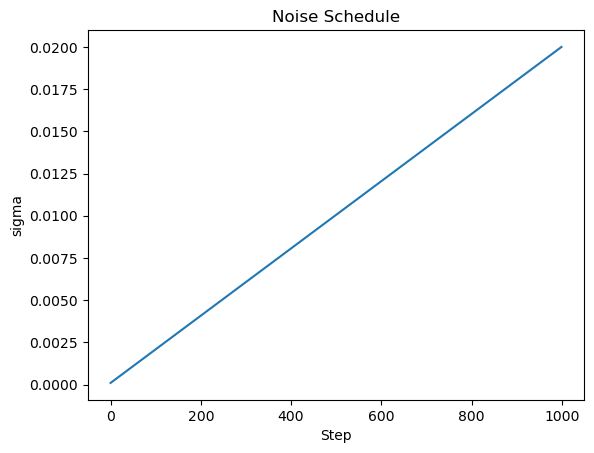

In [24]:
# See these in terms of the original 1000 steps used for training:
# Setting the number of sampling steps:
#scheduler.set_timesteps(15)
plt.plot(noise_scheduler.betas)
plt.title('Noise Schedule')
plt.xlabel('Step')
plt.ylabel('sigma')
plt.show()

Let's see how this noise scheduler works: it takes a batch of images from the trainng set (here we will reuse the batch of one image `sample_image` form before), a batch of random noise of the same shape and the timesteps for each image (which correspond to the number of times we want to apply noise to each image):

In [25]:
import torch
from PIL import Image
time_step_idx = 250

noise = torch.randn(sample_image.shape).cuda()
timesteps = torch.LongTensor([time_step_idx]).cuda()
noisy_sample_image = noise_scheduler.add_noise(sample_image, noise.cuda(), timesteps)
print(noisy_sample_image.shape)
noisy_input_image = torch.cat([noisy_sample_image, condition_image], dim=1)
noisy_decoded_image = latent_to_image(noisy_sample_image)
noisy_decoded_image = to_gray(noisy_decoded_image)
print(noisy_decoded_image.shape)

torch.Size([1, 4, 128, 128])
torch.Size([1, 512, 512])


In [26]:
timesteps

tensor([250], device='cuda:1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


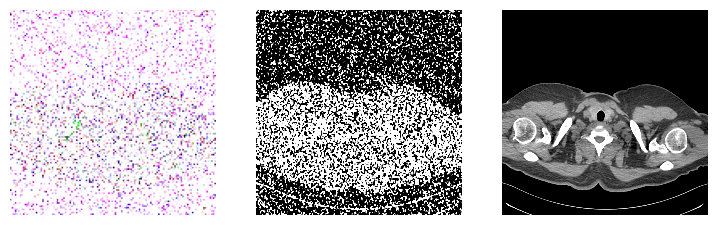

In [27]:
original_image = dataset['train'][0]['imageB']

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(noisy_sample_image[0].cpu().permute(1,2,0), cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(noisy_decoded_image[0].cpu()*norm_scale+norm_mean, cmap='gray', vmin=win_min, vmax=win_max)
axs[1].set_axis_off()
axs[2].imshow(original_image.cpu().permute(1,2,0).squeeze()*norm_scale+norm_mean, cmap='gray', vmin=win_min, vmax=win_max)
axs[2].set_axis_off()


In the DDPM algorithm, the training objective of the model is then to be able to predict the noise we used in `noise_scheduler.add_noise`, so the loss at this step would be:

In [26]:
import torch.nn.functional as F

noise_pred = model(noisy_input_image, timesteps)["sample"]
loss = F.mse_loss(noise_pred, noise)


Clean cuda device

In [27]:
torch.cuda.empty_cache()

## Setting up training

We have all we need to be able to train our model! Let's use a standard AdamW optimizer:

In [28]:
#@title set optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(config.adam_beta1, config.adam_beta2),)

In [29]:
#@title Add a [OPTIONAL: cosine learning rate] schedule:
from diffusers.optimization import get_scheduler, get_cosine_schedule_with_warmup
        
lr_scheduler = get_scheduler(
    config.lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps * config.gradient_accumulation_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## Inference

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk. 

In [30]:
#@title Setting up validation
import math
import os
from scipy.io import loadmat, savemat

def evaluate_image(config, cimages, pipeline, seed, batch=0, out_dir='test'):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        image = cimages,
        num_inference_steps = config.num_inference_timesteps,
        generator = torch.manual_seed(seed),
        output_type = 'numpy',
    ).images
    
    images = to_gray(images)
    images = images.transpose((1,2,0))
    cimages = cimages[:,0,:,:].permute(1,2,0).cpu().numpy()
    
    # Save the matlab/raw files for visualization
    test_dir = os.path.join(config.output_dir, out_dir)
    os.makedirs(test_dir, exist_ok=True)
    savemat(f"{test_dir}/{batch:04d}.mat", {"input": cimages*norm_scale+norm_mean, "output": images*norm_scale+norm_mean})
    
    return images

In [31]:
from pipeline import cLDMPipeline, cDDPMPipeline
import os

trained_model_dir = config.pretrain_dir

inference_seed = 14
test_batch = next(iter(val_dataloader))

if config.latent_diffusion:
    cimages = to_rgb(test_batch['imageA'])
    pipeline = cLDMPipeline.from_pretrained(trained_model_dir)
else:
    cimages = test_batch['imageA']                 
    pipeline = cDDPMPipeline.from_pretrained(trained_model_dir)
    
pipeline = pipeline.to("cuda")    
evaluate_image(config, cimages, pipeline, inference_seed, batch=0, out_dir="test")

# input and label
in_ = test_batch['imageA'][:,0,:,:].permute(1,2,0).cpu().numpy()
truth = test_batch['imageB'][:,0,:,:].permute(1,2,0).cpu().numpy()

# Save the matlab/raw files for visualization
test_dir = os.path.join(config.output_dir, "test")
savemat(f"{test_dir}/0000_label.mat", {"input": in_*norm_scale+norm_mean, "truth": truth*norm_scale+norm_mean})
    
del pipeline
torch.cuda.empty_cache()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

test_dir = os.path.join(config.output_dir, "test")
images = loadmat(f"{test_dir}/0000.mat")
input_image = images['input'].transpose((2,0,1))
output_image = images['output'].transpose((2,0,1))
images = loadmat(f"{test_dir}/0000_label.mat")
truth_image = images['truth'].transpose((2,0,1))

l, r = 25, 400
win_min, win_max = (l-r/2+1024)/4095, (l+r/2+1024)/4095

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(input_image[10:14]):
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(output_image[10:14]):
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(truth_image[10:14]):
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()